# SHAP analysis of RANDM thermospheric density model
This notebook is one companion piece to Bard, Murphy, Halford (2025): "Elucidating the Grey Atmosphere: SHAP Value Analysis of a Random Forest Atmospheric Neutral Density Model".

## Part C: Interaction between Model Features

This notebook uses the saved SHAP explanations from Part A to generate the plots shown in the paper; here, Figures 5-7.

#### Requirements
- numpy
- pandas
- matplotlib
- fasttreeshap
- shap

#### References
- SHAP paper (arxiv link)
- saved SHAP explanations (zenodo link)
- Murphy+2025 (RANDM model paper): https://doi.org/10.1029/2024SW003928
- MLTDM repository: https://github.com/kylermurphy/mltdm/

In [1]:
import numpy as np
import numpy.random as rand
import pandas as pd
import time as pytime
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
import fasttreeshap as fts
from fasttreeshap.plots import beeswarm, waterfall, bar
import shap

In [3]:
# hack to save and load minimal viable explanation, 
# since it takes a while to make
def save_explanation(fname, expln):
    # hack to avoid pickling and associated errors
    dta = expln.data.astype(float)
    np.savez(fname, values=expln.values, 
             base_values=expln.base_values, data=dta,
             feature_names=expln.feature_names, 
             output_names=expln.output_names, compute_time=expln.compute_time)

def load_explanation(fname):
    dat_dict = np.load(fname)
    return fts.Explanation(values = dat_dict["values"], base_values=dat_dict["base_values"], 
                           data=dat_dict["data"], feature_names=dat_dict["feature_names"], 
                           output_names=dat_dict["output_names"], 
                           compute_time=dat_dict["compute_time"])

# hack to blend multiple explanations together
def stack_expln(expln1, expln2):
    return fts.Explanation(values = np.vstack([expln1.values, expln2.values]), 
                             base_values = np.vstack([expln1.base_values, expln2.base_values]), 
                             data = np.vstack([expln1.data, expln2.data]),
                             feature_names=expln1.feature_names,
                            )

In [4]:
# functions to load feature data from hardcoded file
# Download file "FI_GEO_RF_data.h5" from Zenodo : <>

# data columns used in best-performing Murphy RF model
fgeo_col = ['1300_02', '43000_09', '85550_13', '94400_18', 'SYM_H index', 
            'AE', 'SatLat', 'cos_SatMagLT', 'sin_SatMagLT']

def _load_datafile(option: str = "test_d", path='./'):
    """
    Loads forest training/test data from CB's checkpointing of
    the train/test split in KM's Notebook (https://github.com/kylermurphy/mltdm/blob/main/Notebooks/RF_model.ipynb)

    option : str
        1. "test_d" : Grace B test data
        2. "train_d" : Grace B training data
        3. "oos_d" : Grace A
        4. "oos2_d" : CHAMP

    """

    return pd.read_hdf(path+"FI_GEO_RF_data.h5", option)


def load_data(storm: bool = None, option: str = "test_d", all_cols: bool = False, path='./'):
    """
    Loads pandas data array from file in `load_datafile`

    `storm` : bool | None
        1. None : load full data
        2. True : load storm data ("storm" == 1)
        3. False : load nonstorm data ("storm" == -1)

    option : str
        1. "test_d" : Grace B test data
        2. "train_d" : Grace B training data
        3. "oos_d" : Grace A
        4. "oos2_d" : CHAMP

    all_cols : bool
        If True, load all data columns
        If False, load just fgeo_columns used in best RF model

    path : str
        path to find FI_GEO_RF_data.h5 datafile, by default './'
    """

    dat = _load_datafile(option, path=path)

    if storm is not None:
        dat = dat[dat['storm'] == ((storm == True) - (storm == False))]

    return dat if all_cols else dat[fgeo_col]

In [5]:
# random sampler
NUM_SAMP = 2000
def sample(gen, df, num_samp=2000):
    """
    Samples df with num_samp points.

    gen: np.random.rand instance
        Used to generate random indices for sample selection
    df: pandas.dataframe
        data to sample
    num_samp : int
        number of points in sample
    """
    num_samp = min(num_samp, df.shape[0])
    ids = gen.choice(range(df.shape[0]), size = num_samp, replace=False)
    return df.iloc[ids]

### Generate interaction values from sample data

In [6]:
full_data = load_data(all_cols=True, option="test_d") # loads Grace B test data

In [7]:
# sort into more specific datasets
storm_data = full_data[full_data['storm'] == 1]
quiet_data = full_data[full_data['storm'] == -1]

In [8]:
# random sampler
SEED = 693993
gen = rand.default_rng(SEED)

storm_samp_data = sample(gen, storm_data)
quiet_samp_data = sample(gen, quiet_data)

In [9]:
total_samp_data = pd.concat([storm_samp_data, quiet_samp_data])

In [20]:
# WARNING: 10 events took 120 seconds on my laptop, so 2000 events > 6 hours
# recommended to use many-cored CPU
"""
# set to NUM_SAMP to do full sample, 
# but this will take a long time (unless you have many cores)
num_evts = 10
num_evts = min(num_evts, NUM_SAMP)

print("start storm interaction")
tfirst = pytime.perf_counter()
storm_int = explainer.shap_interaction_values(storm_samp_data[fgeo_col].iloc[:num_evts])
tnow = pytime.perf_counter()
print(f"Time taken: {tnow - tfirst}")
if num_evts > 20:
    np.savez("storm_interactions", storm_int)
"""

start storm interaction
Time taken: 120.01980730000014


Or load in the pre-calculated values from Zenodo: <>

In [10]:
# pre-calculated shap values stored in directory:
local_dir = './SHAP_values/'

In [11]:
storm_int = np.load(local_dir+"storm_interactions_firsthalf.npz")['arr_0']
quiet_int = np.load(local_dir+"quiet_interactions_firsthalf.npz")['arr_0']

In [12]:
print(storm_int.shape)
nevts = storm_int.shape[0]

(1000, 9, 9)


In [13]:
storm_int2 = np.load(local_dir+"storm_interactions_secondhalf.npz")['arr_0']
quiet_int2 = np.load(local_dir+"quiet_interactions_secondhalf.npz")['arr_0']

In [14]:
storm_int2.shape

(1000, 9, 9)

In [15]:
all_storm_interactions = np.vstack((storm_int, storm_int2))
all_quiet_interactions = np.vstack((quiet_int, quiet_int2))

In [16]:
all_interactions = np.vstack((all_storm_interactions, all_quiet_interactions))
all_samples = pd.concat((storm_samp_data,quiet_samp_data))

#### Figure 5 (total interactions for full sample)

Code for colored interaction matrix is based on example at end of the linked page:
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/NHANES%20I%20Survival%20Model.html#Compute-SHAP-Interaction-Values

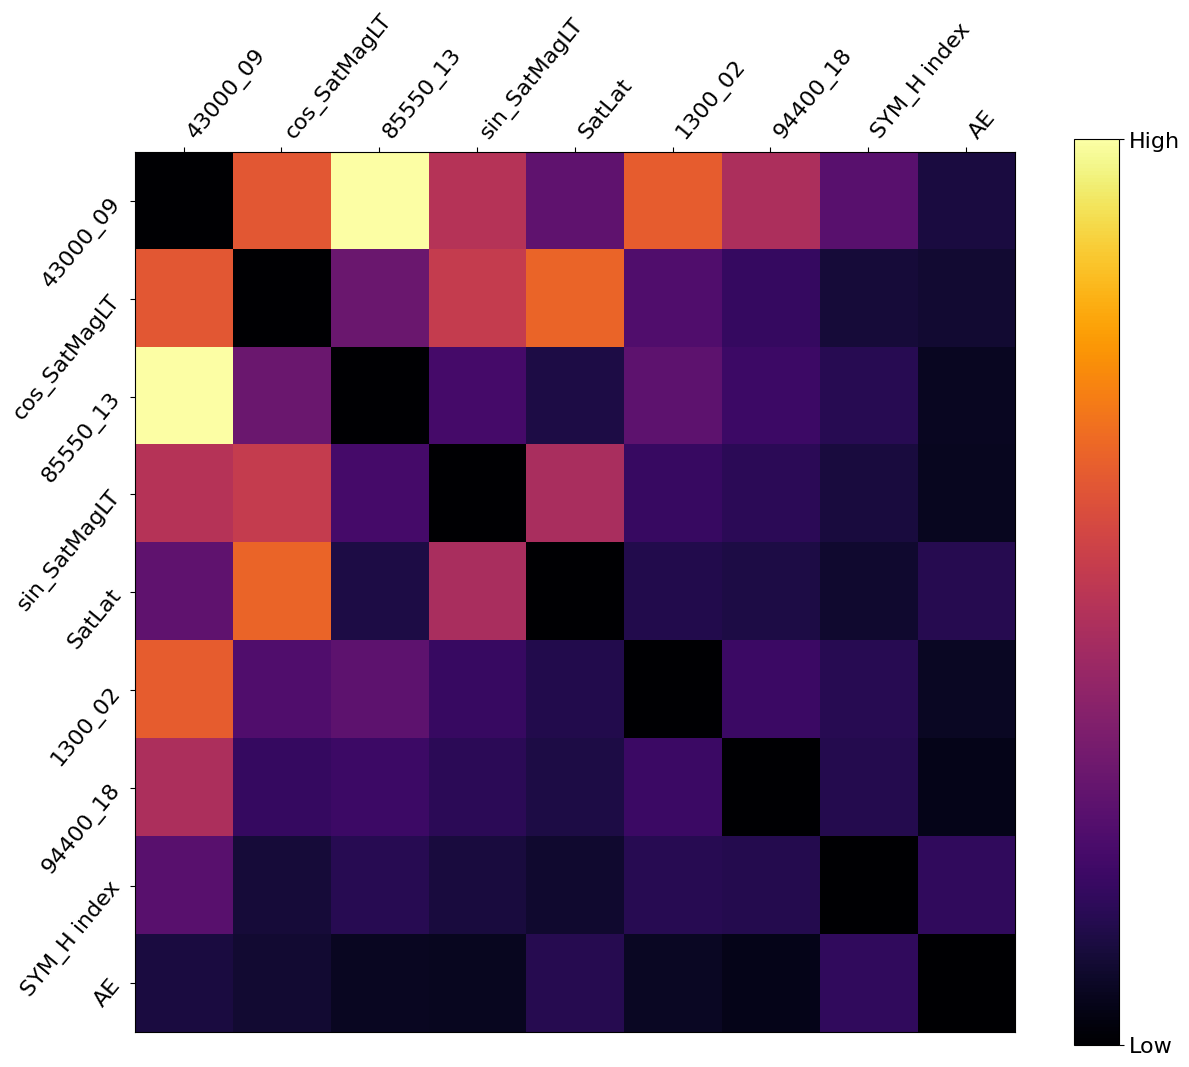

In [19]:
# Making tick marks and labels bigger
interaction_matrix = np.abs(all_interactions).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:12]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
img = ax.imshow(sorted_ia_matrix, cmap=plt.cm.inferno)
ax.set_yticks(
    range(sorted_ia_matrix.shape[0]),
    storm_data[fgeo_col].columns[inds],
    rotation=50.4,
    horizontalalignment="right",
    size=16,
)
ax.set_xticks(
    range(sorted_ia_matrix.shape[0]),
    storm_data[fgeo_col].columns[inds],
    rotation=50.4,
    horizontalalignment="left",
    size=16,
)
ax.xaxis.tick_top()
cbar = fig.colorbar(img,ax=ax, fraction=0.046, pad=0.06, ticks=[0,sorted_ia_matrix.max()])
cbar.ax.set_yticklabels(['Low', 'High'], size=16)  # vertically oriented colorbar
fig.tight_layout()
#fig.savefig("all_interaction_matrix_paper2.png")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


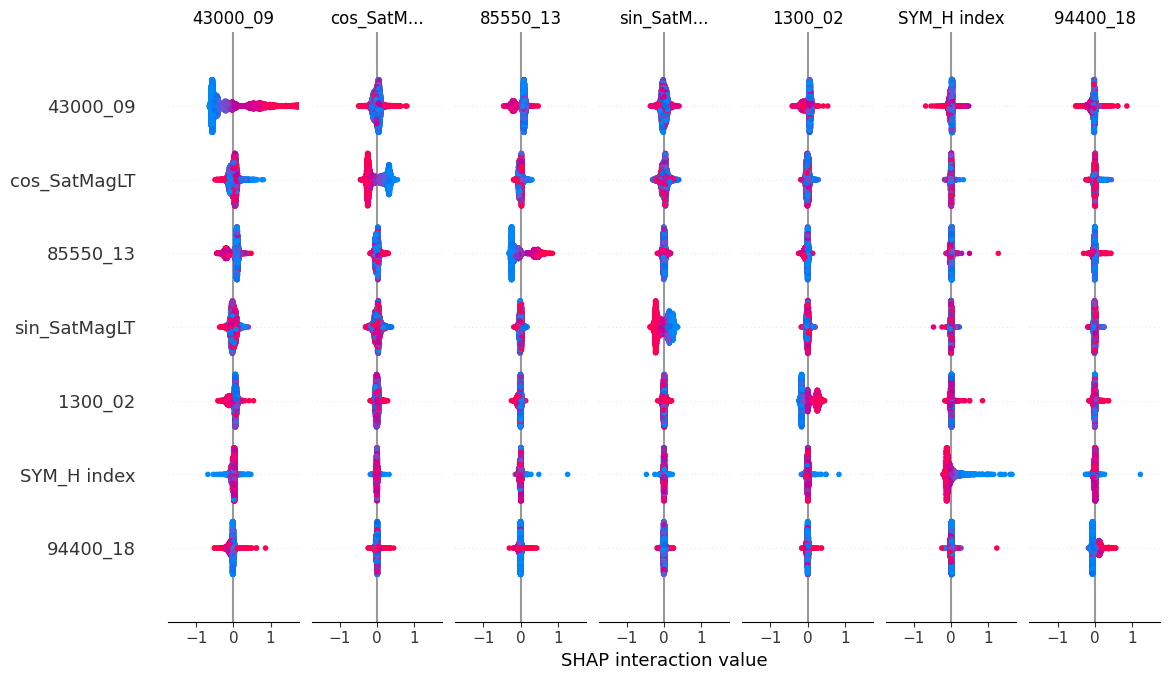

In [18]:
# this is the full summary plot for interactions (not used in paper)
fts.summary_plot(all_interactions, all_samples[fgeo_col])

In [123]:
f = plt.gcf()
f.savefig("all_int_summary.png", bbox_inches="tight")
f.clf()

##### other full interaction plots

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


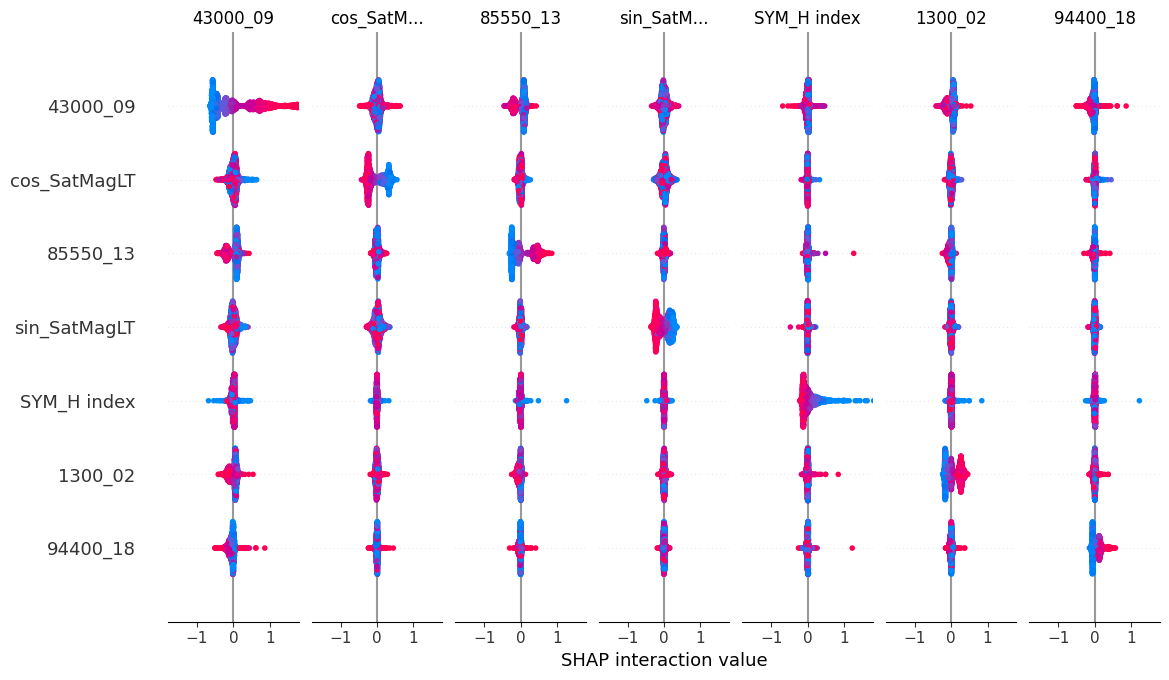

In [20]:
fts.summary_plot(all_storm_interactions, storm_samp_data[fgeo_col])

In [87]:
f = plt.gcf()
f.savefig("storm_int_summary.png", bbox_inches="tight")
f.clf()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


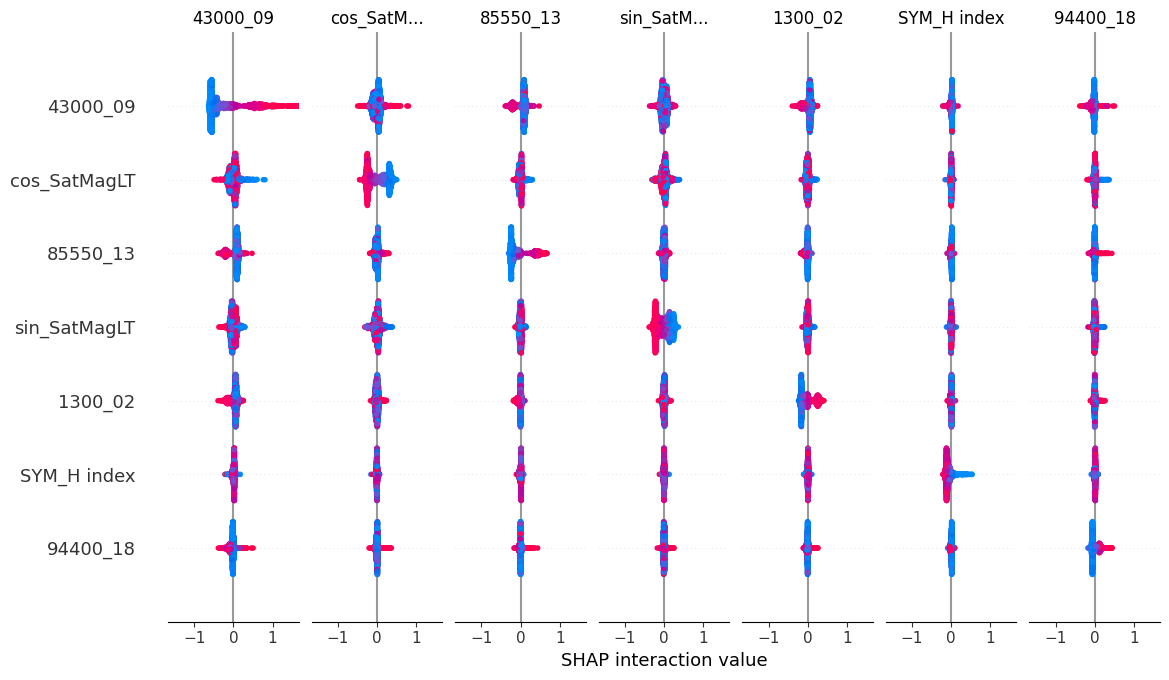

In [21]:
fts.summary_plot(all_quiet_interactions, quiet_samp_data[fgeo_col])

In [89]:
f = plt.gcf()
f.savefig("quiet_int_summary.png", bbox_inches="tight")
f.clf()

#### Figure 6: 43 nm Main Feature and Cross-Interactions

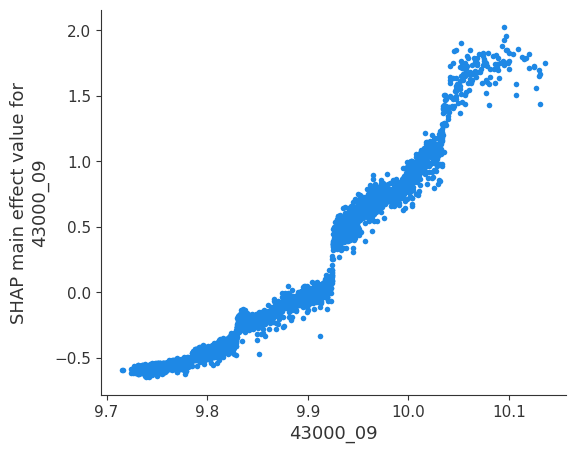

In [22]:
# Main feature
fts.dependence_plot(("43000_09", "43000_09"), all_interactions, all_samples[fgeo_col])

In [126]:
f = plt.gcf()
f.savefig("test_dependence_43.png", bbox_inches="tight")
f.clf()

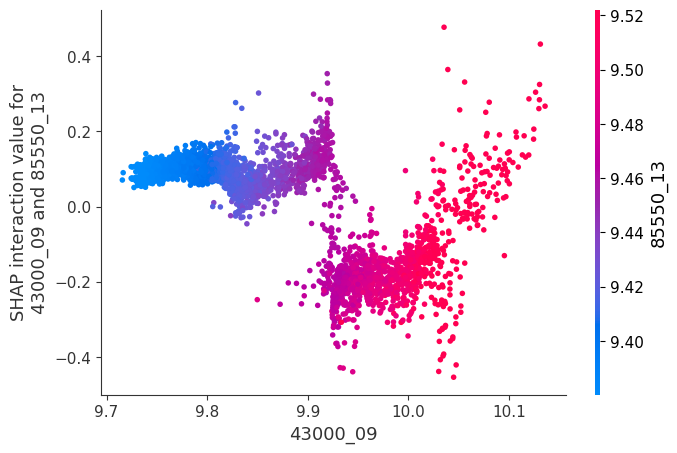

In [23]:
fts.dependence_plot(("43000_09", "85550_13"), all_interactions, all_samples[fgeo_col])

In [128]:
f = plt.gcf()
f.savefig("test_dependence_4385.png", bbox_inches="tight")
f.clf()

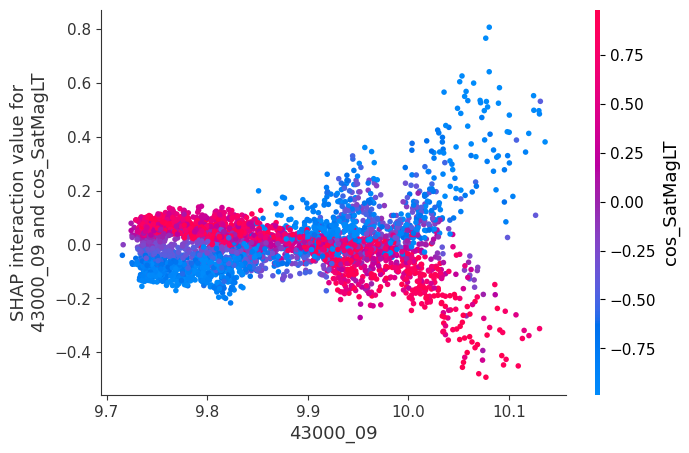

In [24]:
fts.dependence_plot(("43000_09", "cos_SatMagLT"), all_interactions, all_samples[fgeo_col])

In [130]:
f = plt.gcf()
f.savefig("test_dependence_43cos.png", bbox_inches="tight")
f.clf()

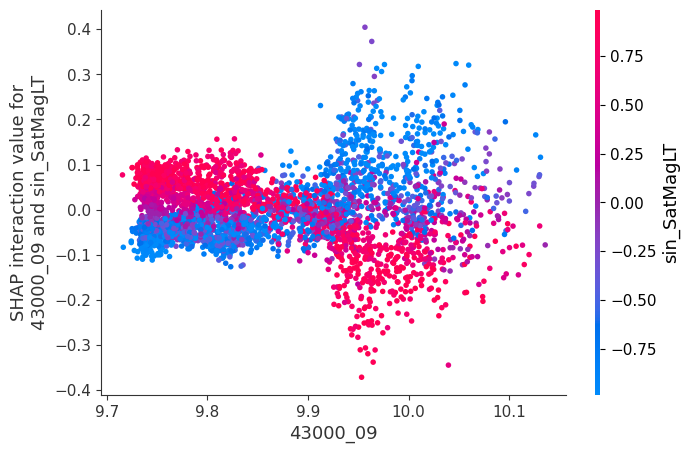

In [25]:
fts.dependence_plot(("43000_09", "sin_SatMagLT"), all_interactions, all_samples[fgeo_col])

In [140]:
f = plt.gcf()
f.savefig("test_dependence_43sin.png", bbox_inches="tight")
f.clf()

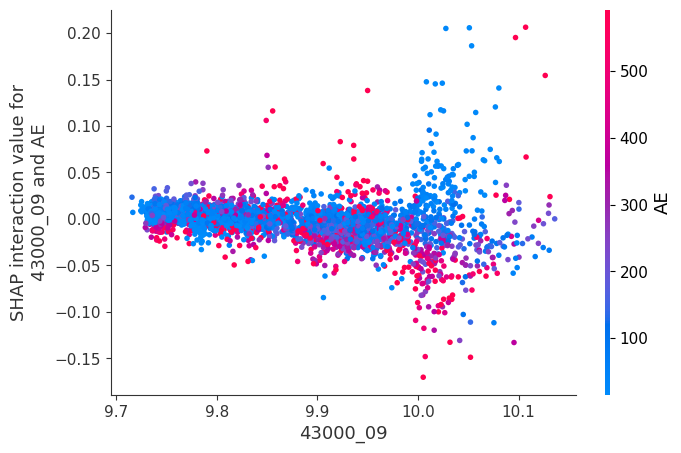

In [26]:
fts.dependence_plot(("43000_09", "AE"), all_interactions, all_samples[fgeo_col])

In [142]:
f = plt.gcf()
f.savefig("test_dependence_43AE.png", bbox_inches="tight")
f.clf()

#### Figure 7: cos(MLT) Main Feature and Cross-Interactions

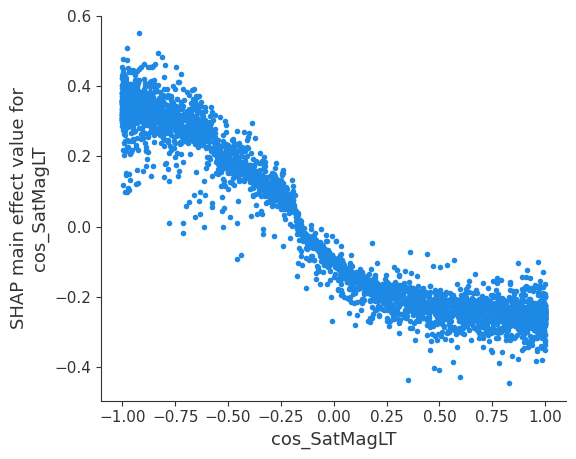

In [27]:
fts.dependence_plot(("cos_SatMagLT","cos_SatMagLT"), all_interactions, all_samples[fgeo_col])

In [132]:
f = plt.gcf()
f.savefig("test_dependence_cos.png", bbox_inches="tight")
f.clf()

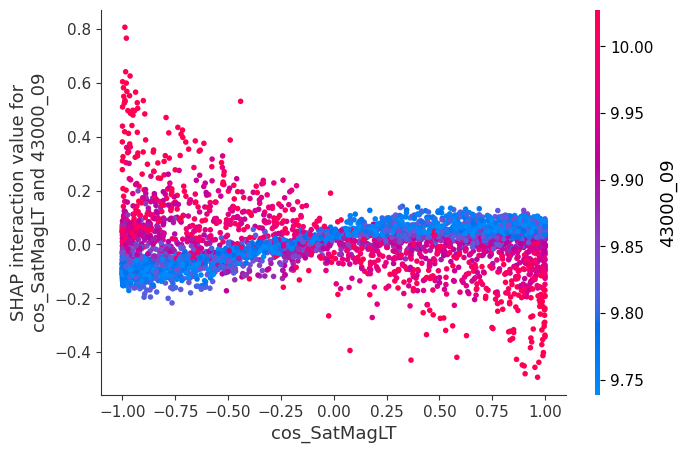

In [28]:
fts.dependence_plot(("cos_SatMagLT","43000_09"), all_interactions, all_samples[fgeo_col])

In [134]:
f = plt.gcf()
f.savefig("test_dependence_cos43.png", bbox_inches="tight")
f.clf()

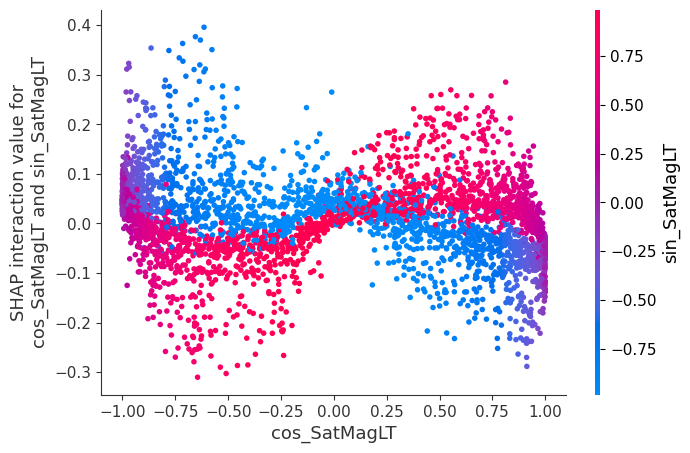

In [29]:
fts.dependence_plot(("cos_SatMagLT","sin_SatMagLT"), all_interactions, all_samples[fgeo_col])

In [144]:
f = plt.gcf()
f.savefig("test_dependence_cossin.png", bbox_inches="tight")
f.clf()

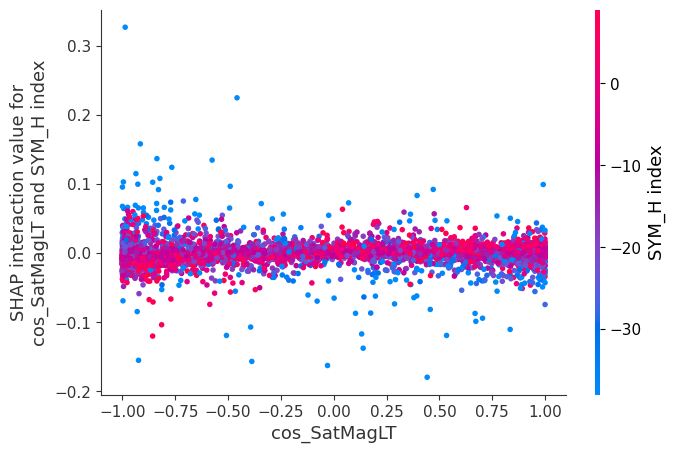

In [30]:
fts.dependence_plot(("cos_SatMagLT","SYM_H index"), all_interactions, all_samples[fgeo_col])

In [197]:
f = plt.gcf()
f.savefig("test_dependence_cosSYM.png", bbox_inches="tight")
f.clf()

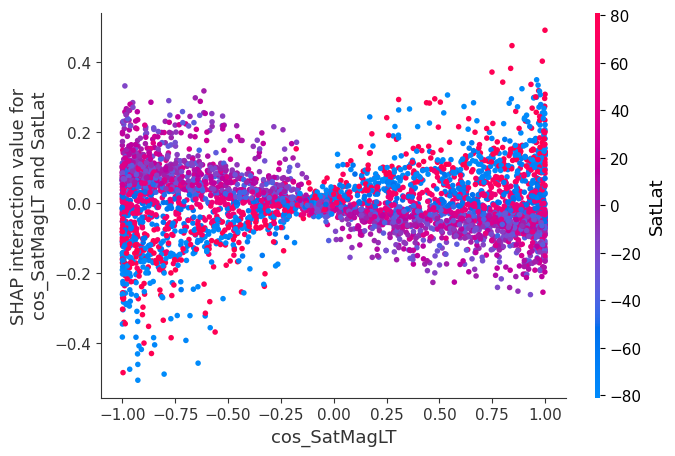

In [31]:
fts.dependence_plot(("cos_SatMagLT", "SatLat"), all_interactions, all_samples[fgeo_col])

In [136]:
f = plt.gcf()
f.savefig("test_dependence_cosSLat.png", bbox_inches="tight")
f.clf()

##### other examples

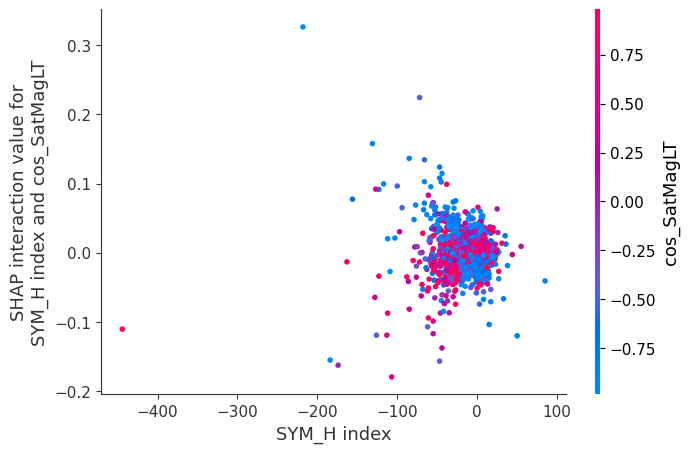

In [32]:
fts.dependence_plot(("SYM_H index", "cos_SatMagLT"), all_interactions, all_samples[fgeo_col])

In [191]:
f = plt.gcf()
f.savefig("test_dependence_SYMcos.png", bbox_inches="tight")
f.clf()

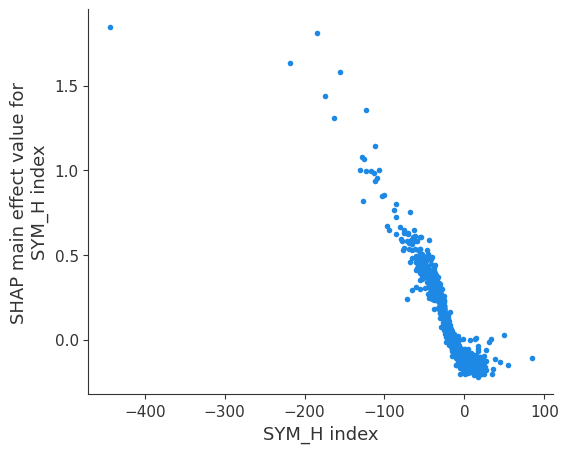

In [33]:
fts.dependence_plot(("SYM_H index","SYM_H index"), all_interactions, all_samples[fgeo_col])

In [193]:
f = plt.gcf()
f.savefig("test_dependence_SYM.png", bbox_inches="tight")
f.clf()

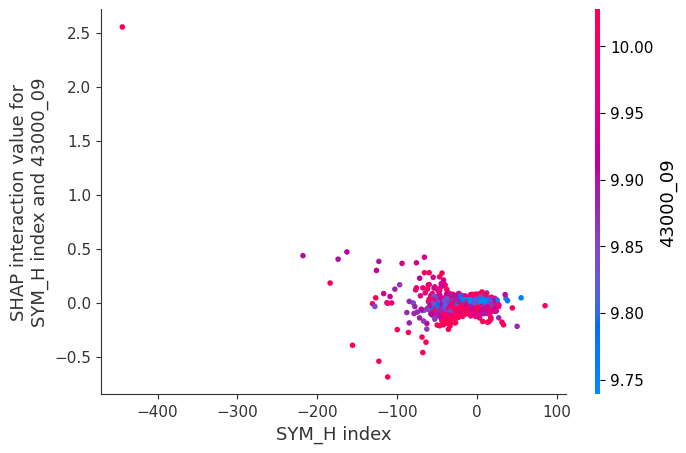

In [34]:
fts.dependence_plot(("SYM_H index","43000_09"), all_interactions, all_samples[fgeo_col])

In [195]:
f = plt.gcf()
f.savefig("test_dependence_SYM43.png", bbox_inches="tight")
f.clf()

##### end

The next notebook, Part D, will feature analysis of **individual events**